# <span style='font-family:"Times New Roman"'> <span styel=''> **DATA CLEAN UP**

<span style='font-family:"Times New Roman"'> <span styel=''> *Emile Cohen* 
    
*March 2020*

**Goal:** In this notebook, we assess the right purity/ccf threshold to cut the uncertain samples while keeping enough samples for our study.



**NB1:** In each part, you must run the cells from the begining in order to initialize the variables

**NB2:** All functions used for the plots are located in utils/custom_tools.py

---

In [1]:
%run -i '../../utils/setup_environment.ipy'
from utils.analysis_tools import *

import warnings, math

warnings.filterwarnings('ignore')
import ptitprince as pt
import IPython.display
from itertools import cycle, islice
from lifelines import KaplanMeierFitter

data_path = '../../data/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

---

In [2]:
master = pd.read_pickle(data_path + 'merged_data/master_file.pkl')

In [140]:
sns.set_style("whitegrid", {'grid.color': '0.98'})
my_colors = list(islice(cycle(list(sns.color_palette("muted"))), None, 6))

def annotate_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.tick_params(labelbottom=True, labelleft=True)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)


def def_fig_set(figsize=(15, 12), number=6):
    fig = plt.figure(figsize=figsize)
    if number == 6:
        ax1 = plt.subplot2grid(shape=(3, 7), loc=(0, 0), colspan=3)
        ax2 = plt.subplot2grid((3, 7), (0, 4), colspan=3)
        ax3 = plt.subplot2grid((3, 7), (1, 0), colspan=3)
        ax4 = plt.subplot2grid((3, 7), (1, 4), colspan=3)
        ax5 = plt.subplot2grid((3, 7), (2, 0), colspan=3)
        ax6 = plt.subplot2grid((3, 7), (2, 4), colspan=3)

    if number == 5:
        ax1 = plt.subplot2grid(shape=(3, 7), loc=(0, 0), colspan=3)
        ax2 = plt.subplot2grid((3, 7), (0, 4), colspan=3)
        ax3 = plt.subplot2grid((3, 7), (1, 0), colspan=3)
        ax4 = plt.subplot2grid((3, 7), (1, 4), colspan=3)
        ax5 = plt.subplot2grid((3, 7), (2, 2), colspan=3)

    if number == 4:
        ax1 = plt.subplot2grid(shape=(3, 7), loc=(0, 0), colspan=3)
        ax2 = plt.subplot2grid((3, 7), (0, 4), colspan=3)
        ax3 = plt.subplot2grid((3, 7), (1, 0), colspan=3)
        ax4 = plt.subplot2grid((3, 7), (1, 4), colspan=3)

    annotate_axes(fig)

    return fig


def get_densities(master: pd.DataFrame,
                  metrics: str,
                  fig_title: str,
                  xlabel,
                  ylabel,
                  number=6,
                  met_prim: str = None,
                  clip=(0.0, 3.0),
                  x_lim=[0, 1]):
    # We initialize the figure
    fig = def_fig_set(number=number)
    fig.tight_layout(pad=10, w_pad=0.5, h_pad=10)
    fig.suptitle(fig_title, fontsize=16, weight='bold')

    # We differentiate the groups if we have
    if number == 6:
        groups = [
            '>=1_LOSS', 'HOMDEL', '1_WILD_TYPE', '>1muts', '>=1_cnLOH',
            '0_HETLOSS'
        ]
    if number == 5:
        groups = ['>=1_LOSS', 'HOMDEL', '1_WILD_TYPE', '>1muts', '>=1_cnLOH']  
    
    for ax, group, i in zip(fig.axes, groups, range(len(groups))):
        data = master[master['mut_cn_group'] == group]
        if met_prim:
            data = data[data['Sample_Type'] == met_prim]
        sns.distplot(data[metrics],
                     hist=False,
                     kde_kws={
                         'clip': clip,
                         "shade": True
                     },
                     ax=ax,
                     color=my_colors[i])
        ax.set_xlim(x_lim)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

        # Adding Mean and Median Information
        mean = round(data[metrics].mean(), 2)
        median = round(data[metrics].median(), 2)
        string = 'Mean: ' + str(mean) + '\nMedian: ' + str(median)
        ax.axvline(mean, color='g', linestyle='-', label='Mean: ' + str(mean))
        ax.axvline(median,
                   color='b',
                   linestyle='-',
                   label='Median: ' + str(median))
        ax.legend()

        ax.set_title(group, weight='bold')

        
def compute_median_interval(x):
    median_list = []
    for group in [
            '>=1_cnLOH', '1_WILD_TYPE', '>1muts', 'HOMDEL', '>=1_LOSS',
            '0_HETLOSS'
    ]:
        median_list.append(master[master['mut_cn_group'] == group][master['purity']> x.purity]['purity'].median())
    
    return [round(min(median_list),2), round(max(median_list),2)]
            
            
            
def cut_master(master: pd.DataFrame, range_: list, threshold: float):
    '''
    This function returns the table of population quartiles for the parameters set and shows
    the purity andd ccf densities for the parameters.
    
    Arguments:
        - master: Dataframe
        - to_cut: column on which we want to cut. Example: 'purity'
        - threshold: betwwen 0 and 1 to cut the low range samples
    '''
    for group in [
            '>=1_cnLOH', '1_WILD_TYPE', '>1muts', 'HOMDEL', '>=1_LOSS',
            '0_HETLOSS'
    ]:
        a = pd.DataFrame(master[master['mut_cn_group'] == group])
        h = [len(a[a['purity'] <= x]) for x in range_]
        h_df = pd.DataFrame(h, columns=[group], index=range_)
        if group == '>=1_cnLOH':
            h_tot = h_df
        else:
            h_tot = pd.concat([h_tot, h_df], axis=1)

    h_tot['SUM'] = h_tot.apply(sum, axis=1)
    h_tot['ratio'] = h_tot.apply(lambda x : 100*round(x.SUM / list(h_tot['SUM'])[-1], 3), axis=1)
    h_tot['purity'] = list(h_tot.index.values)
    h_tot['purity_median_interval'] = h_tot.apply(compute_median_interval, axis=1)
    h_tot = h_tot.drop('purity', axis=1)

    
    
    master_cut = master[master['purity'] > threshold]
    get_densities(master_cut,
                  'purity',
                  fig_title='Purity',
                  xlabel='Purity',
                  ylabel='Density')
    get_densities(master_cut,
                  'ccf_1',
                  fig_title='CCF',
                  xlabel='ccf',
                  ylabel='Density',
                  number=5)
    return h_tot

,>=1_cnLOH,1_WILD_TYPE,>1muts,HOMDEL,>=1_LOSS,0_HETLOSS,SUM,ratio,purity_median_interval
0.20,70,239,39,4,135,57,544,3.8,"[0.32, 0.52]"
0.21,98,303,52,4,210,85,752,5.3,"[0.33, 0.52]"
0.22,117,377,62,6,323,116,1001,7.0,"[0.34, 0.52]"
0.23,135,443,74,13,429,149,1243,8.7,"[0.36, 0.53]"
0.24,174,497,86,16,535,191,1499,10.5,"[0.37, 0.54]"
0.25,219,553,95,19,657,237,1780,12.5,"[0.38, 0.54]"
0.26,245,600,106,21,807,287,2066,14.5,"[0.39, 0.54]"
0.27,282,655,131,27,937,344,2376,16.7,"[0.41, 0.55]"
0.28,323,709,151,38,1062,383,2666,18.7,"[0.42, 0.55]"
0.30,405,785,183,43,1355,470,3241,22.7,"[0.45, 0.56]"


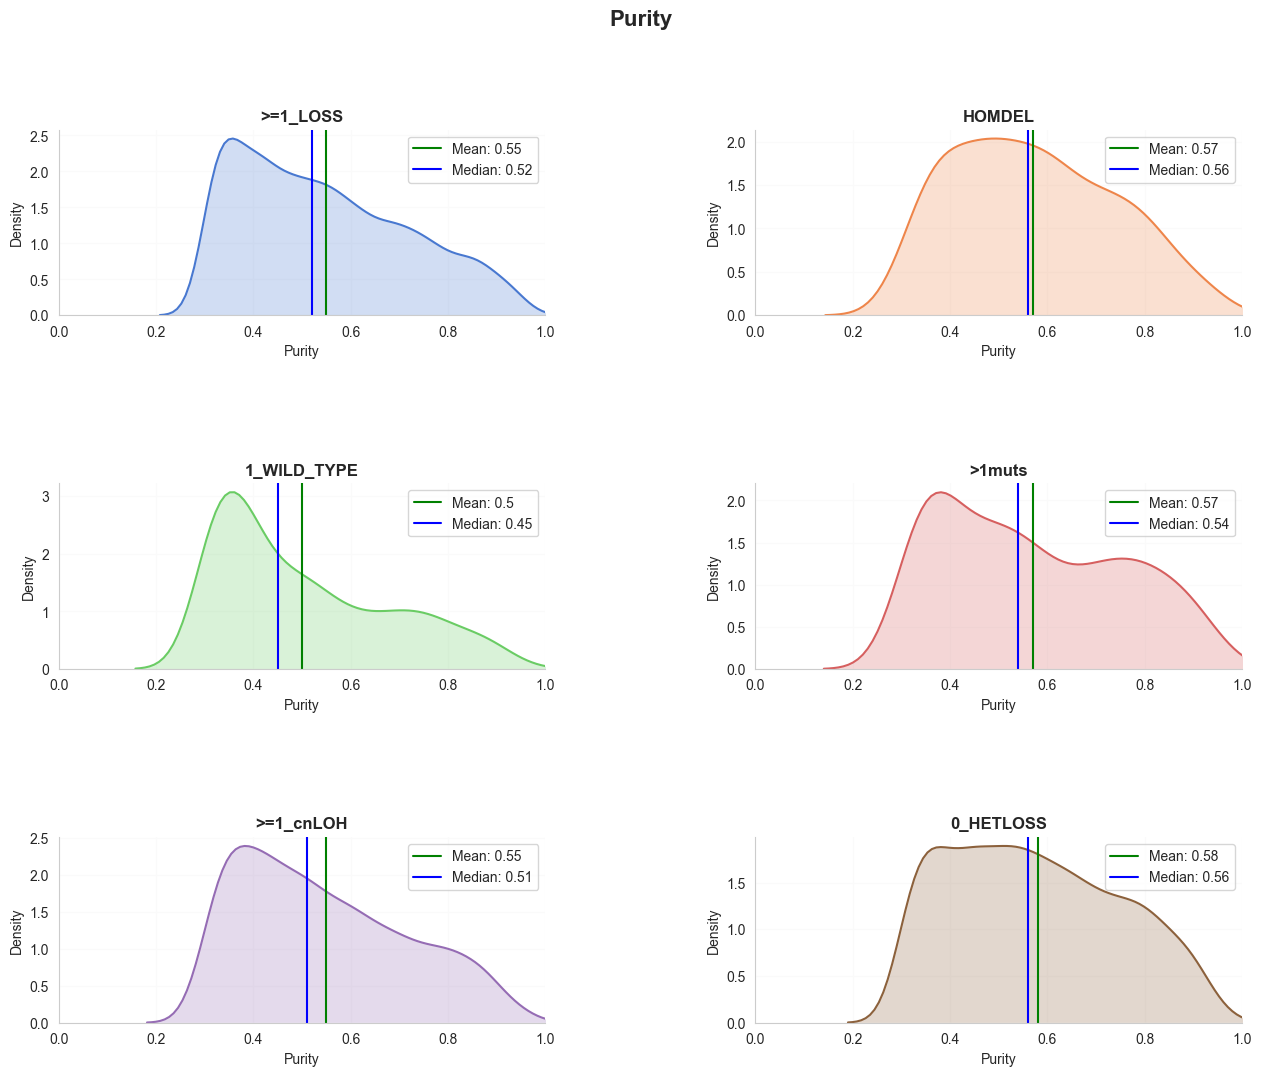

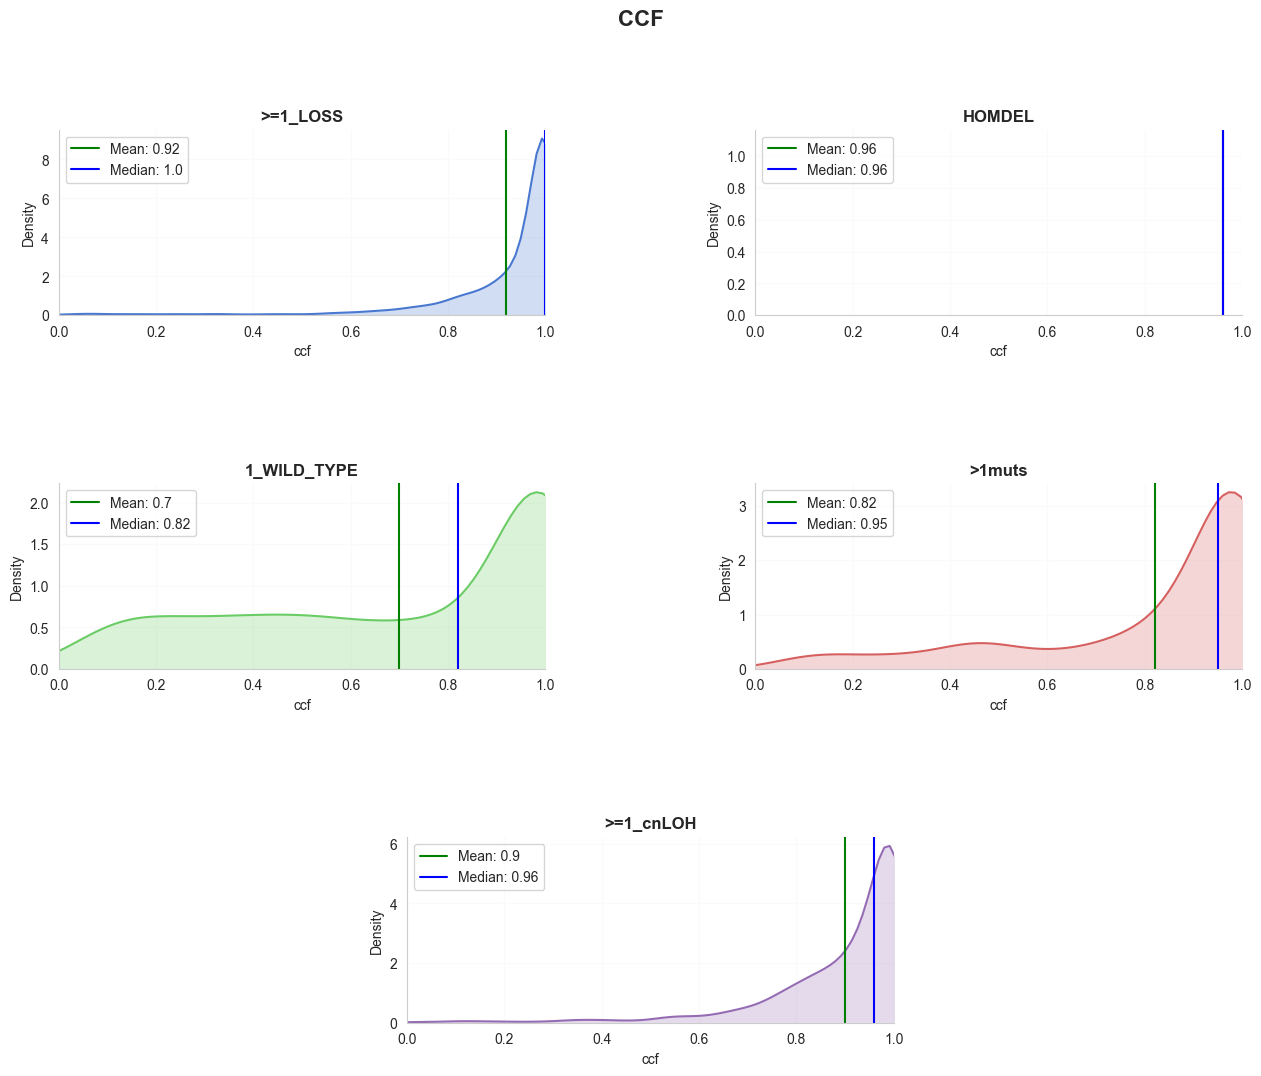

In [151]:
cut_master(master, range_ = [0.2,0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37, 0.4,0.6,0.8,1], threshold=0.30)